Hunter Bennett | Strains Project | June 16 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
# dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet/strains_f1/results/01_CB6F1_MultiOmic/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [4]:
if not os.path.isdir('./motif_enrichment_scatters/'):
    os.mkdir('./motif_enrichment_scatters/')

In [5]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('../00_CB6F1_Control_ATAC/motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame_atac = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame_atac = known_motif_pval_frame_atac.reindex(known_motif_pval_frame_atac.mean(axis=1).sort_values().index.tolist())

# known_motif_pval_frame.to_csv('./homer_known_motifs_all.txt', sep='\t')

In [6]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('../00_CB6F1_Control/motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame_h3k27ac = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame_h3k27ac = known_motif_pval_frame_h3k27ac.reindex(known_motif_pval_frame_h3k27ac.mean(axis=1).sort_values().index.tolist())


# Make combo scatter

In [7]:
from scipy.stats import spearmanr, pearsonr

In [8]:
viridis = matplotlib.cm.get_cmap('viridis')
colors = [viridis(0.6), viridis(0.2), viridis(0.4)]

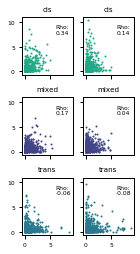

In [10]:

fig, axs = plt.subplots(3, 2, figsize=(2,4),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(hspace=0.4)

for settype, color, ax, in zip(['cis', 'mixed', 'trans'], colors, axs[:, 0]):

    ax.scatter(-known_motif_pval_frame_atac.loc[:, 'atac_%s_balb_hunterFCThenPadj_motifs' % settype],
                   -known_motif_pval_frame_atac.loc[:, 'atac_%s_c57_hunterFCThenPadj_motifs'% settype],
                   s=1,
                   c=[color])
    
    corr = spearmanr(-known_motif_pval_frame_atac.loc[:, 'atac_%s_balb_hunterFCThenPadj_motifs' % settype],
                            -known_motif_pval_frame_atac.loc[:, 'atac_%s_c57_hunterFCThenPadj_motifs'% settype])
    
    ax.text(6.0, 7.5, 'Rho:\n%.2f' % corr.correlation)
    
    # ax.set_ylabel('C57BL/6J')
    ax.set_title(settype)

for settype, color, ax, in zip(['cis', 'mixed', 'trans'], colors, axs[:, 1]):

    ax.scatter(-known_motif_pval_frame_h3k27ac.loc[:, 'h3k27ac_%s_balb_hunterFCThenPadj_motifs' % settype],
                   -known_motif_pval_frame_h3k27ac.loc[:, 'h3k27ac_%s_c57_hunterFCThenPadj_motifs'% settype],
                   s=1,
                   c=[color])
    
    corr = spearmanr(-known_motif_pval_frame_h3k27ac.loc[:, 'h3k27ac_%s_balb_hunterFCThenPadj_motifs' % settype],
                            -known_motif_pval_frame_h3k27ac.loc[:, 'h3k27ac_%s_c57_hunterFCThenPadj_motifs'% settype])
    
    ax.text(6.0, 7.5, 'Rho:\n%.2f' % corr.correlation)
    
    # ax.set_ylabel('C57BL/6J')
    ax.set_title(settype)
    
# axs[2,0].set_xlabel('BALB/cJ')
# axs[2,1].set_xlabel('BALB/cJ')

plt.savefig('./motif_enrichment_scatters/shared_motif_enrichment_scatter.pdf',
            bbox_inches='tight')

In [12]:
df_atac.columns

Index(['atac_cis_balb_hunterFCThenPadj_distal_motifs',
       'atac_cis_c57_hunterFCThenPadj_distal_motifs',
       'atac_mixed_balb_hunterFCThenPadj_distal_motifs',
       'atac_mixed_c57_hunterFCThenPadj_distal_motifs',
       'atac_trans_balb_hunterFCThenPadj_distal_motifs',
       'atac_trans_c57_hunterFCThenPadj_distal_motifs'],
      dtype='object')

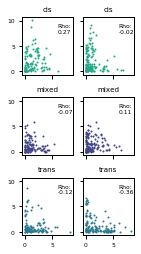

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(2,4),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(hspace=0.4)

for settype, color, ax, in zip(['cis', 'mixed', 'trans'], colors, axs[:, 0]):
    
    # filter data - only comparisons we are considering
    df_atac = known_motif_pval_frame_atac.loc[:, known_motif_pval_frame_atac.columns.str.contains('hunterFCThenPadj')]
    df_atac = df_atac.loc[:, ~df_atac.columns.str.contains('distal')]
    # require one to be significant
    df_atac = df_atac.loc[(df_atac < np.log(0.05)).any(1), :]

    ax.scatter(-df_atac.loc[:, 'atac_%s_balb_hunterFCThenPadj_motifs' % settype],
               -df_atac.loc[:, 'atac_%s_c57_hunterFCThenPadj_motifs'% settype],
               s=1,
               c=[color])
    
    corr = spearmanr(df_atac.loc[:, 'atac_%s_balb_hunterFCThenPadj_motifs' % settype],
                     df_atac.loc[:, 'atac_%s_c57_hunterFCThenPadj_motifs'% settype])
    
    ax.text(6.0, 7.5, 'Rho:\n%.2f' % corr[0])
    
    # ax.set_ylabel('C57BL/6J')
    ax.set_title(settype)

for settype, color, ax, in zip(['cis', 'mixed', 'trans'], colors, axs[:, 1]):
    
    # filter data - only comparisons we are considering
    df_h3k27ac = known_motif_pval_frame_h3k27ac.loc[:, known_motif_pval_frame_h3k27ac.columns.str.contains('hunterFCThenPadj')]
    df_h3k27ac = df_h3k27ac.loc[:, ~df_h3k27ac.columns.str.contains('distal')]
    # require one to be significant
    df_h3k27ac = df_h3k27ac.loc[(df_h3k27ac < np.log(0.05)).any(1), :]

    ax.scatter(-df_h3k27ac.loc[:, 'h3k27ac_%s_balb_hunterFCThenPadj_motifs' % settype],
               -df_h3k27ac.loc[:, 'h3k27ac_%s_c57_hunterFCThenPadj_motifs'% settype],
               s=1,
               c=[color])
    
    corr = spearmanr(df_h3k27ac.loc[:, 'h3k27ac_%s_balb_hunterFCThenPadj_motifs' % settype],
                    df_h3k27ac.loc[:, 'h3k27ac_%s_c57_hunterFCThenPadj_motifs'% settype])
    
    ax.text(6.0, 7.5, 'Rho:\n%.2f' % corr[0])
    
    # ax.set_ylabel('C57BL/6J')
    ax.set_title(settype)
    
# axs[2,0].set_xlabel('BALB/cJ')
# axs[2,1].set_xlabel('BALB/cJ')

plt.savefig('./motif_enrichment_scatters/shared_motif_enrichment_scatter_filtered.pdf',
            bbox_inches='tight')